```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Inventory Dynamics

```{include} _admonition/gpu.md
```

```{index} single: Markov process, inventory
```

```{contents} Contents
:depth: 2
```

## Overview

This lecture explores JAX implementations of the exercises in the lecture on [inventory dynamics](https://python.quantecon.org/inventory_dynamics.html).

We will use the following imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, lax
from collections import namedtuple

Let's check the GPU we are running

In [2]:
!nvidia-smi

Thu May 18 10:05:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    43W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


## Sample paths

Consider a firm with inventory $X_t$.

The firm waits until $X_t \leq s$ and then restocks up to $S$ units.

It faces stochastic demand $\{ D_t \}$, which we assume is IID.

With notation $a^+ := \max\{a, 0\}$, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

(See our earlier [lecture on inventory dynamics](https://python.quantecon.org/inventory_dynamics.html) for background and motivation.)

In what follows, we will assume that each $D_t$ is lognormal, so that

$$
    D_t = \exp(\mu + \sigma Z_t)
$$

where $\mu$ and $\sigma$ are parameters and $\{Z_t\}$ is IID
and standard normal.

Here's a `namedtuple` that stores parameters.

In [3]:
Firm = namedtuple('Firm', ['s', 'S', 'mu', 'sigma'])

firm = Firm(s=10, S=100, mu=1.0, sigma=0.5)

## Example 1: marginal distributions

Now let’s look at the marginal distribution $\psi_T$ of $X_T$ for some fixed
$T$.

We can approximate the distribution using a [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation).

Kernel density estimators can be thought of as smoothed histograms.

We will use a kernel density estimator from [scikit-learn](https://scikit-learn.org/stable/).

Here is an example of using kernel density estimators and plotting the result

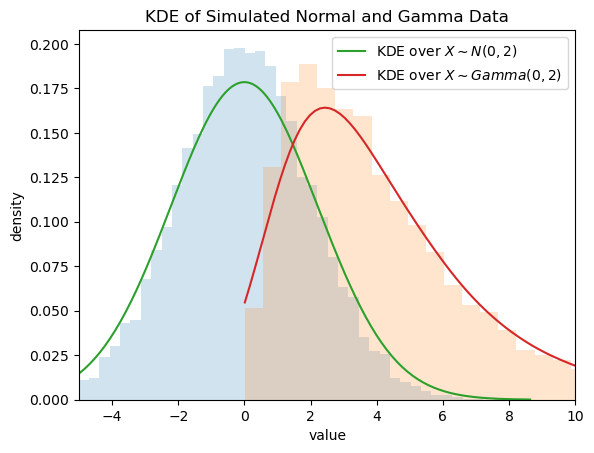

In [4]:
from sklearn.neighbors import KernelDensity

def plot_kde(sample, ax, label=''):
    xmin, xmax = 0.9 * min(sample), 1.1 * max(sample)
    xgrid = np.linspace(xmin, xmax, 200)
    kde = KernelDensity(kernel='gaussian').fit(sample[:, None])
    log_dens = kde.score_samples(xgrid[:, None])

    ax.plot(xgrid, np.exp(log_dens), label=label)

# Generate simulated data
np.random.seed(42)
sample_1 = np.random.normal(0, 2, size=10_000)
sample_2 = np.random.gamma(2, 2, size=10_000)

# Create a plot
fig, ax = plt.subplots()

# Plot the samples
ax.hist(sample_1, alpha=0.2, density=True, bins=50)
ax.hist(sample_2, alpha=0.2, density=True, bins=50)

# Plot the KDE for each sample
plot_kde(sample_1, ax, label=r'KDE over $X \sim N(0, 2)$')
plot_kde(sample_2, ax, label=r'KDE over $X \sim Gamma(0, 2)$')
ax.set_xlabel('value')
ax.set_ylabel('density')
ax.set_xlim([-5, 10])
ax.set_title('KDE of Simulated Normal and Gamma Data')
ax.legend()
plt.show()

This model for inventory dynamics is asymptotically stationary, with a unique
stationary distribution.

In particular, the sequence of marginal distributions $\{\psi_t\}$
converges to a unique limiting distribution that does not depend on
initial conditions.

Although we will not prove this here, we can investigate it using simulation.

We can generate and plot the sequence $\{\psi_t\}$ at times
$t = 10, 50, 250, 500, 750$ based on the kernel density estimator.

We will see convergence, in the sense that differences between successive
distributions are getting smaller.

Here is one realization of the process in JAX using `for` loop

In [5]:
# Define a jit-compiled function to update X and key
@jax.jit
def update_X(X, firm, D):
    # Restock if the inventory is below the threshold
    res = jnp.where(X <= firm.s,
            jnp.maximum(firm.S - D, 0),
            jnp.maximum(X - D, 0))
    return res


def shift_firms_forward(x_init, firm, sample_dates, 
                        key, num_firms=50_000, sim_length=750):
    
    X = res = jnp.full((num_firms, ), x_init)

    # Use for loop to update X and collect samples
    for i in range(sim_length):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(firm.mu + firm.sigma * Z)
        
        X = update_X(X, firm, D)
        _, key = random.split(key)
        
        # draw a sample at the sample dates
        if (i in sample_dates):
          res = jnp.vstack((res, X))

    return res[1:]

CPU times: user 2.89 s, sys: 471 ms, total: 3.36 s
Wall time: 2.69 s


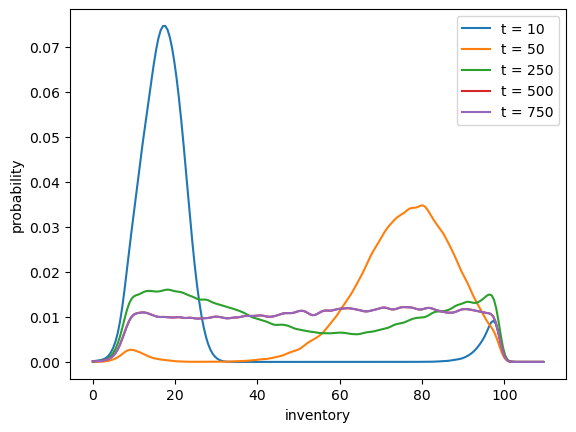

In [6]:
x_init = 50
num_firms = 50_000
sample_dates = 10, 50, 250, 500, 750
key = random.PRNGKey(10)

fig, ax = plt.subplots()

%time X = shift_firms_forward(x_init, firm, \
                              sample_dates, key).block_until_ready()

for i, date in enumerate(sample_dates):
   plot_kde(X[i, :], ax, label=f't = {date}')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

Note that we did not JIT-compile the outer loop, since

1. `jit` compilation of the `for` loop can be very time consuming and
1. compiling outer loops only leads to minor speed gains.


### Alternative implementation with `lax.scan`

An alternative to the `for` loop implementation is `lax.scan`.

Here is an example of the same function in `lax.scan`

In [7]:
@jax.jit
def shift_firms_forward(x_init, firm, key,
                        num_firms=50_000, sim_length=750):
    
    s, S, mu, sigma = firm.s, firm.S, firm.mu, firm.sigma
    X = jnp.full((num_firms, ), x_init)
    Z = random.normal(key, shape=(sim_length, num_firms))
    D = jnp.exp(mu + sigma * Z)
    
    # Define the function for each update
    def update_X(X, D):
        res = jnp.where(X <= s, 
                  jnp.maximum(S - D, 0), 
                  jnp.maximum(X - D, 0))
        return res, res

    # Use lax.scan to perform the calculations on all states
    _, X_final = lax.scan(update_X, X, D)

    return X_final

The benefit of the `lax.scan` implementation is that we compile the whole
operation.

The disadvantages are that

1. as mentioned above, there are only limited speed gains in accelerating outer loops,
2. `lax.scan` has a more complicated syntax, and, most importantly,
3. the `lax.scan` implementation consumes far more memory, as we need to have to
   store large matrices of random draws


Let's call the code to generate a cross-section that is in approximate
equilibrium.

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 390 ms


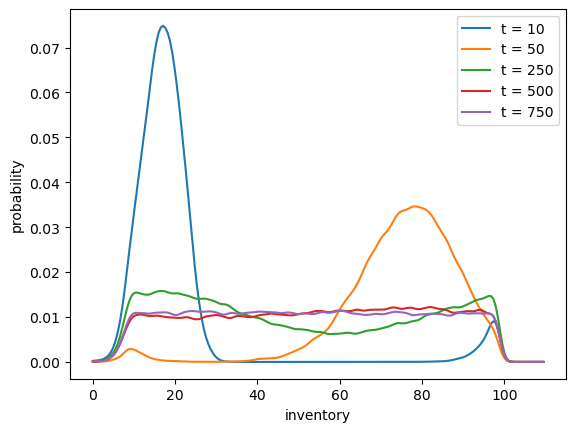

In [8]:
fig, ax = plt.subplots()

%time X = shift_firms_forward(x_init, firm, key).block_until_ready()

for date in sample_dates:
   plot_kde(X[date, :], ax, label=f't = {date}')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

Notice that by $t=500$ or $t=750$ the densities are barely
changing.

We have reached a reasonable approximation of the stationary density.

You can test a few more initial conditions to show that they do not affect
long-run outcomes.

For example, try rerunning the code above with all firms starting at
$X_0 = 20$

CPU times: user 887 ms, sys: 0 ns, total: 887 ms
Wall time: 309 ms


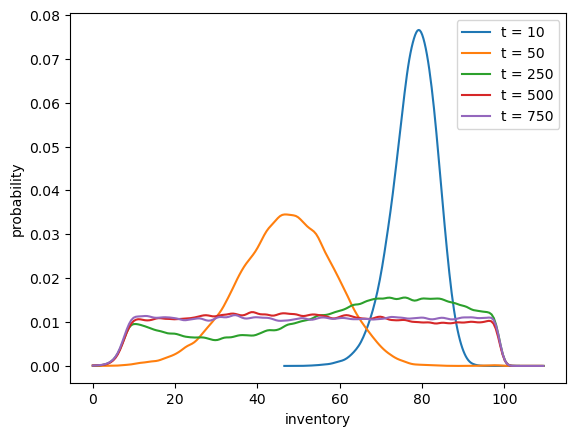

In [9]:
x_init = 20.0

fig, ax = plt.subplots()

%time X = shift_firms_forward(x_init, firm, key).block_until_ready()

for date in sample_dates:
   plot_kde(X[date, :], ax, label=f't = {date}')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

## Example 2: restock frequency

Let's go through another example where we calculate the probability of firms
having restocks.  

Specifically we set the starting stock level to 70 ($X_0 = 70$), as we calculate
the proportion of firms that need to order twice or more in the first 50
periods.

You will need a large sample size to get an accurate reading.

Again, we start with an easier `for` loop implementation

In [10]:
# Define a jitted function for each update
@jax.jit
def update_stock(n_restock, X, firm, D):
  n_restock = jnp.where(X <= firm.s,
                        n_restock + 1,
                        n_restock)
  X = jnp.where(X <= firm.s,
                jnp.maximum(firm.S - D, 0),
                jnp.maximum(X - D, 0))
  return n_restock, X, key

def compute_freq(firm, key, 
                 x_init=70, 
                 sim_length=50, 
                 num_firms=1_000_000):
    
    # Prepare initial arrays
    X = jnp.full((num_firms, ), x_init)

    # Stack the restock counter on top of the inventory
    n_restock = jnp.zeros((num_firms, ))

    # Use a for loop to perform the calculations on all states
    for i in range(sim_length):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(firm.mu + firm.sigma * Z)
        n_restock, X, key = update_stock(
            n_restock, X, firm, D)
        key = random.fold_in(key, i)
        
    return jnp.mean(n_restock > 1, axis=0)

In [11]:
key = random.PRNGKey(27)
%time freq = compute_freq(firm, key).block_until_ready()
print(f"Frequency of at least two stock outs = {freq}")

CPU times: user 964 ms, sys: 0 ns, total: 964 ms
Wall time: 1.22 s
Frequency of at least two stock outs = 0.4472379982471466


### Alternative implementation with `lax.scan`

Now let's write a `lax.scan` version that JIT compiles the whole function

In [12]:
@jax.jit
def compute_freq(firm, key, 
                 x_init=70, 
                 sim_length=50, 
                 num_firms=1_000_000):
    
    s, S, mu, sigma = firm.s, firm.S, firm.mu, firm.sigma
    # Prepare initial arrays
    X = jnp.full((num_firms, ), x_init)
    Z = random.normal(key, shape=(sim_length, num_firms))
    D = jnp.exp(mu + sigma * Z)

    # Stack the restock counter on top of the inventory
    restock_count = jnp.zeros((num_firms, ))
    Xs = jnp.vstack((X, restock_count))

    # Define the function for each update
    def update_X(Xs, D):

        # Separate the inventory and restock counter
        X = Xs[0]
        restock_count =  Xs[1]

        restock_count = jnp.where(X <= s,
                            restock_count + 1,
                            restock_count)
        X = jnp.where(X <= s, 
                      jnp.maximum(S - D, 0),
                      jnp.maximum(X - D, 0))
        
        Xs = jnp.vstack((X, restock_count))
        return Xs, None

    # Use lax.scan to perform the calculations on all states
    X_final, _ = lax.scan(update_X, Xs, D)

    return np.mean(X_final[1] > 1)

Note the time the routine takes to run, as well as the output

In [13]:
%time freq = compute_freq(firm, key).block_until_ready()
print(f"Frequency of at least two stock outs = {freq}")

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 399 ms
Frequency of at least two stock outs = 0.44674399495124817
